#### Importing libraries

In [384]:
import pandas as pd 
import numpy as np
import pandas_profiling 

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import BASE_COLORS

import seaborn as sns
sns.set()

from statsmodels.formula.api import ols
import statsmodels.api as sm

from janitor import groupby_agg

from scipy import stats

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import plotly
import plotly.graph_objs as go

In [385]:
import warnings 
warnings.filterwarnings("ignore")

#### Importing data

In [386]:
data = pd.read_csv("data2.csv", encoding= 'unicode_escape')

## Initial exploring, cleaning and wrangling

In [387]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [388]:
data.shape

(541909, 8)

##### This data contains online retail store transaction from 38 countries by 4372 customers. There are 541,909 observations and 8 features for 53 weeks starting from 1st Dec 2010 to 9th Dec 2011. Many of the customers are wholesalers. 

InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. "D" indicates discount.

Description: Product (item) name. Nominal.

Quantity: The quantities of each product (item) per transaction. Numeric.

InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.

UnitPrice: Unit price. Numeric, Product price per unit in sterling.

CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

Country: Country name. Nominal, the name of the country where each customer resides.

In [389]:
print("Our last data point is on", data["InvoiceDate"].max())

Our last data point is on 9/9/2011 9:52


In [390]:
round(data.isnull().sum()/len(data)*100, 2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [391]:
print("25 %, or", data["CustomerID"].isnull().sum(), "entries are null values, will explore this further")

25 %, or 135080 entries are null values, will explore this further


In [392]:
data[data.Description.isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom


When the description is missing, so is the customerID and the price is = 0. Maybe these are other types of entries, programming error etc. Will be a problem when later when doing the customer segmentation, will therefore delete them. 

In [393]:
data = data.dropna(subset=["CustomerID"])

In [394]:
data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Deleting the null values in CustomerID also got rid of the other null values.

In [395]:
data[data['UnitPrice'] == 0].count()

InvoiceNo      40
StockCode      40
Description    40
Quantity       40
InvoiceDate    40
UnitPrice      40
CustomerID     40
Country        40
dtype: int64

In [396]:
print(len(data[data['UnitPrice'] == 0]), "values where the unit price is = 0 , this could be a discount or similar, will remove these to make better analyses on average sales etc.")

40 values where the unit price is = 0 , this could be a discount or similar, will remove these to make better analyses on average sales etc.


In [397]:
data = data[data['UnitPrice'] != 0]

In [398]:
data.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [399]:
data['InvoiceDate']=pd.to_datetime(data['InvoiceDate'])

In [400]:
print(data.duplicated().sum(), "entries are duplicates, this could be due to programming error etc. These are dropped for further analysis")

5225 entries are duplicates, this could be due to programming error etc. These are dropped for further analysis


In [401]:
data.drop_duplicates(inplace = True)

## Adding columns for further exploring

In [402]:
data["TotalSold"] = data.Quantity * data.UnitPrice
data["Weekday"] = data.InvoiceDate.dt.day_name()
data["Cancellation"]=data.InvoiceNo.apply(lambda x: "Yes" if x[0]=="C" else "No")
data["Hour"]=data.InvoiceDate.dt.hour
data["Month"]=data.InvoiceDate.dt.month
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSold,Weekday,Cancellation,Hour,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,Wednesday,No,8,12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,Wednesday,No,8,12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,Wednesday,No,8,12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,Wednesday,No,8,12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,Wednesday,No,8,12


## Findings from exploring data in Tableau

Exporting data for further analysis using Tableau

In [403]:
# data.to_csv("ecommerce_data.csv")

#### Year
- Sales increase over the year, especially in September to December building up to Christmas

#### Days
- Total sales per weekday arequite normally distributed during the week, peak Thursday, less acticity on Sundays 
- No business on Saturday

#### Hours
- Business hours between 7 am 8 pm on Wednesday, Thurday and Friday
- Business hours between 7 am 8 pm on Monday and Tuesday
- Sunday business hours: 9 am - 4 pm
- Peak hours between 10 am and 1 pm

#### Countries 
- The UK stands for almost 82 % of the total sales
- Also sell to Europe, Australia, North America, Saudi Arabia and Brazil

#### Other
- Every row of order consists of one type of product for quantity x, most rows have a value of between 0 and 25 pound
- The dataset contains about 2 % of cancelled orders, for a cancel to be made there first needs to be an order, sometimes this order also exists in our dataset and sometimes it happened before the time of the dataset



### Cancellations

In [404]:
data[data['Cancellation'] == 'Yes'].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSold,Weekday,Cancellation,Hour,Month
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,-27.50,Wednesday,Yes,9,12
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,-4.65,Wednesday,Yes,9,12
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,-19.80,Wednesday,Yes,10,12
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,-6.96,Wednesday,Yes,10,12
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,-6.96,Wednesday,Yes,10,12


In [405]:
data[data['Cancellation'] == 'Yes'].tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSold,Weekday,Cancellation,Hour,Month
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom,-9.13,Friday,Yes,9,12
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom,-224.69,Friday,Yes,10,12
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom,-54.75,Friday,Yes,11,12
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom,-1.25,Friday,Yes,11,12
541717,C581569,20979,36 PENCILS TUBE RED RETROSPOT,-5,2011-12-09 11:58:00,1.25,17315.0,United Kingdom,-6.25,Friday,Yes,11,12


In [406]:
print(len(data[data['Cancellation'] == 'Yes']), "orders were cancelled")

8872 orders were cancelled


Since cancellations always follow an order, we want keep them in our analysis to make sure that we don't make the transactions/sales appear bigger then they are.

### Stock codes

In [407]:
data[data['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK'],
      dtype=object)

These specific operations that, a part from disconts (D) and cancellations (C), do not characterize our customers and their purchases. Will drop these for further analysis.

In [408]:
data = data[data['StockCode']!= 'POST']
data = data[data['StockCode']!= 'M']
data = data[data['StockCode']!= 'BANK CHARGES']
data = data[data['StockCode']!= 'PADS']
data = data[data['StockCode']!= 'DOT']

## Statistical Hypothesis Testing

Looking at the data in Tableau we could see that the sales varied between months, days, hours and countries. To further examine this, and to see if the variation is significant, statistical tests are performed.

### Countries

H0: Sales are not affected by the country of the purchase

Ha: Sales are affected by the country of the purchase

*Given two set of observations, x and y, we want to test the hypothesis that y is a linear function of x. In other terms:
Fit a linear model. We will use the simplest strategy, ordinary least squares (OLS), to see if the variables affect on sales is significant.*

In [409]:
model = ols("TotalSold ~ C(Country)",data=data).fit()

table = sm.stats.anova_lm(model, typ=2)
print(table)

                  sum_sq        df         F        PR(>F)
C(Country)  4.044642e+07      36.0  6.210075  6.394452e-29
Residual    7.233916e+10  399846.0       NaN           NaN


*P-value far less than 0.05, we can reject the null hypothesis. Sales varies between the countries.*

### Hour

H0: Sales are not affected by the hour of the purchase

Ha: Sales are affected by the hour of the purchase

In [410]:
model = ols("TotalSold  ~ C(Hour)",data=data).fit()

table = sm.stats.anova_lm(model, typ=2)
print(table)

                sum_sq        df         F    PR(>F)
C(Hour)   9.830867e+06      14.0  3.879924  0.000001
Residual  7.236977e+10  399868.0       NaN       NaN


*P-value far less than 0.05, we can reject the null hypothesis. Sales vary by hour of the day.*

### Weekday

H0: Sales are not affected by the day of the purchase

Ha: Sales are affected by the day of the purchase

In [411]:
model = ols("TotalSold ~ C(Weekday)",data=data).fit()

table = sm.stats.anova_lm(model, typ=2)
print(table)

                  sum_sq        df         F    PR(>F)
C(Weekday)  5.528015e+06       5.0  6.108613  0.000012
Residual    7.237408e+10  399877.0       NaN       NaN


*P-value far less than 0.05, we can reject the null hypothesis. Sales vary by the day of the week.*

### Month

H0: Sales are not affected by the month of the purchase

Ha: Sales are affected by the month of the purchase

In [412]:
data_except_final_month = data[data["InvoiceDate"] <= "2011-12-01 00:00:00"]

*Excluding final month since there's not data for the whole of December*

In [413]:
model = ols("TotalSold ~ C(Month)",data=data_except_final_month).fit()

table = sm.stats.anova_lm(model, typ=2)
print(table)

                sum_sq        df         F    PR(>F)
C(Month)  1.589895e+06      11.0  3.565142  0.000049
Residual  1.550936e+10  382556.0       NaN       NaN


*P-value far less than 0.05, we can reject the null hypothesis. Sales vary by the month of the year.*

# Customer Segmentation using RFM Analysis

RFM stands for the three dimensions:

Recency – How recently did the customer purchase?

Frequency – How often do they purchase?

Monetary Value – How much do they spend?

*RFM analysis is a marketing technique used to determine quantitatively which customers are the best ones, the ones we need to invest more in and who we should ignore.*

In [414]:
data["Recency"] = data.groupby(['CustomerID'])['InvoiceDate'].transform('max') 
data["Days_Since_Last_Purchase"] = data["InvoiceDate"].max() - data["Recency"] 

In [415]:
data = data.groupby_agg(
    by='CustomerID',
    agg='count',
    agg_column_name='InvoiceNo',
    new_column_name='Frequency'
)

data = data.groupby_agg(
    by='CustomerID',
    agg='sum',
    agg_column_name='TotalSold',
    new_column_name='Monetary_Value'
)

In [416]:
data_RFM = data[["CustomerID", "Recency","Days_Since_Last_Purchase", "Frequency", "Monetary_Value"]]

In [417]:
data_RFM["Days_Since_Last_Purchase"] = data_RFM["Days_Since_Last_Purchase"].dt.days

In [418]:
data_RFM.head()

,CustomerID,Recency,Days_Since_Last_Purchase,Frequency,Monetary_Value
0,17850.0,2011-02-10 14:38:00,301,309,5303.48
1,17850.0,2011-02-10 14:38:00,301,309,5303.48
2,17850.0,2011-02-10 14:38:00,301,309,5303.48
3,17850.0,2011-02-10 14:38:00,301,309,5303.48
4,17850.0,2011-02-10 14:38:00,301,309,5303.48


Since we have all the information we need on a specific customer on one row, we can drop all duplicates

In [419]:
data_RFM.drop_duplicates(inplace = True)

In [420]:
print(len(data_RFM), "unique customers")

4362 unique customers


## Exploring the data

In [421]:
data_RFM.describe()

,CustomerID,Days_Since_Last_Purchase,Frequency,Monetary_Value
count,4362.000000,4362.000000,4362.000000,4362.000000
mean,15300.241403,91.172627,91.674232,1893.279065
std,1721.771258,100.965619,228.933961,8267.277690
min,12346.000000,0.000000,1.000000,-1192.200000
25%,13814.250000,16.000000,17.000000,292.527500
50%,15299.500000,49.000000,41.000000,642.545000
75%,16777.750000,142.000000,99.000000,1582.015000
max,18287.000000,373.000000,7800.000000,278571.620000


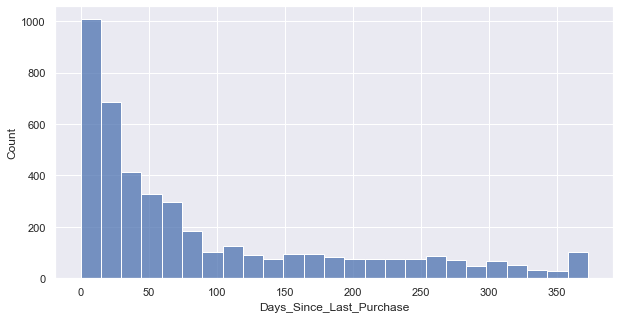

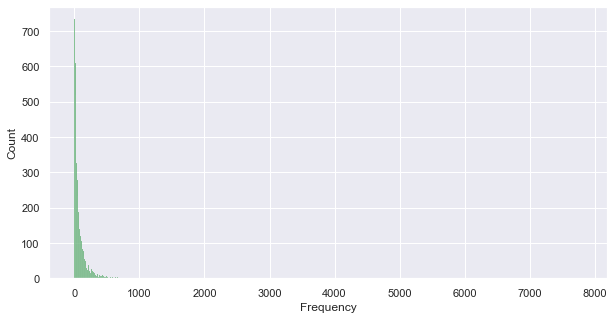

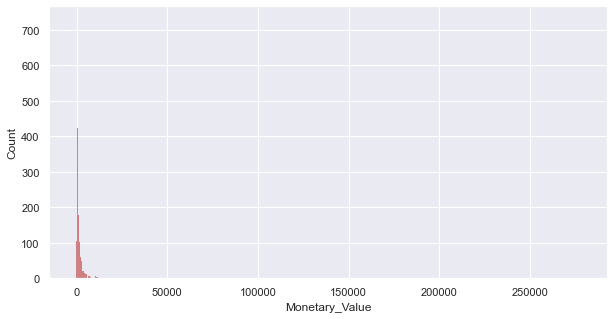

In [422]:
def df_hist(df):
    sns.set(rc={'figure.figsize':(10,5)})
    for i, col in enumerate(df):
        plt.figure(i)
        sns.histplot(df[col], color = list(BASE_COLORS.keys())[i])
        
    plt.show()

df_hist(data_RFM[["Days_Since_Last_Purchase", "Frequency", "Monetary_Value"]])

## Calculating the RFM score and assigning the segment

##### Splitting metrics into segments using quantiles. Score 1-4, 1 being the best. The final RFM score is then calculated by combining the values.

For this part of the RFM segmentation I want to especially thank Miljan Stojiljkovic and his notebook on kaggle for inspiration. 
https://www.kaggle.com/miljan/customer-segmentation/

In [423]:
quantiles = data_RFM.quantile(q=[0.25,0.50,0.75])
quantiles = quantiles.to_dict()

In [424]:
segmented_RFM = data_RFM.copy()

In [425]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [426]:
segmented_RFM['R_quartile'] = segmented_RFM['Days_Since_Last_Purchase'].apply(RScore, args=('Days_Since_Last_Purchase',quantiles))
segmented_RFM['F_quartile'] = segmented_RFM['Frequency'].apply(FMScore, args=('Frequency',quantiles))
segmented_RFM['M_quartile'] = segmented_RFM['Monetary_Value'].apply(FMScore, args=('Monetary_Value',quantiles))
segmented_RFM.head()

,CustomerID,Recency,Days_Since_Last_Purchase,Frequency,Monetary_Value,R_quartile,F_quartile,M_quartile
0,17850.0,2011-02-10 14:38:00,301,309,5303.48,4,1,1
9,13047.0,2011-10-24 14:02:00,45,194,3089.10,2,1,1
26,12583.0,2011-12-07 08:07:00,2,235,6629.34,1,1,1
46,13748.0,2011-09-05 09:45:00,95,28,948.25,3,3,2
65,15100.0,2011-01-13 17:09:00,329,6,635.10,4,4,3


##### Best Recency score = 1: Purchased very recently 
##### Best Frequency score = 1: Highest quantity purchases. 
##### Best Monetary score = 1: Spent the most.

### Giving the segment

In [427]:
segmented_RFM['RFM_Segment'] = segmented_RFM.R_quartile.map(str)+segmented_RFM.F_quartile.map(str)+segmented_RFM.M_quartile.map(str)
segmented_RFM.head()

,CustomerID,Recency,Days_Since_Last_Purchase,Frequency,Monetary_Value,R_quartile,F_quartile,M_quartile,RFM_Segment
0,17850.0,2011-02-10 14:38:00,301,309,5303.48,4,1,1,411
9,13047.0,2011-10-24 14:02:00,45,194,3089.10,2,1,1,211
26,12583.0,2011-12-07 08:07:00,2,235,6629.34,1,1,1,111
46,13748.0,2011-09-05 09:45:00,95,28,948.25,3,3,2,332
65,15100.0,2011-01-13 17:09:00,329,6,635.10,4,4,3,443


### Giving the score

In [428]:
segmented_RFM['RFM_Score'] = segmented_RFM[['R_quartile','F_quartile','M_quartile']].sum(axis=1)
segmented_RFM.head()

,CustomerID,Recency,Days_Since_Last_Purchase,Frequency,Monetary_Value,R_quartile,F_quartile,M_quartile,RFM_Segment,RFM_Score
0,17850.0,2011-02-10 14:38:00,301,309,5303.48,4,1,1,411,6
9,13047.0,2011-10-24 14:02:00,45,194,3089.10,2,1,1,211,4
26,12583.0,2011-12-07 08:07:00,2,235,6629.34,1,1,1,111,3
46,13748.0,2011-09-05 09:45:00,95,28,948.25,3,3,2,332,8
65,15100.0,2011-01-13 17:09:00,329,6,635.10,4,4,3,443,11


For further vizualisations using Tableau

In [429]:
#segmented_RFM.to_csv("segments_data.csv")

### Suggested marketing strategies on segmented customers:

In [430]:
print("Best Customers: ",len(segmented_RFM[segmented_RFM['RFM_Segment']=='111']), "\n- Market them new products, hook them on loyalty programs")
print("\n"'Loyal Customers: ',len(segmented_RFM[segmented_RFM['F_quartile']==1]), "\n- Show appreciation, keep them loyal, engage them, ask for reviews ")
print("\nBig Spenders: ",len(segmented_RFM[segmented_RFM['M_quartile']==1]), "\n- Market them expensive products")
print("\nRecent Spenders: ",len(segmented_RFM[segmented_RFM['R_quartile']==1]), "\n- Market them products based on recent purchases, start building a relationship")
print('\nPromising: ', (len(segmented_RFM[segmented_RFM['RFM_Segment']=='133']) + len(segmented_RFM[segmented_RFM['RFM_Segment']=='122'])) + len(segmented_RFM[segmented_RFM['RFM_Segment']=='123']) + len(segmented_RFM[segmented_RFM['RFM_Segment']=='132']), "\n- Market them products based on recent purchases, create brand awareness")
print('\nLost Cheap Customers: ',len(segmented_RFM[segmented_RFM['RFM_Segment']=='444']), "\n- Let them go")
print('\nLost Big Spenders: ',(len(segmented_RFM[segmented_RFM['RFM_Segment']=='441']) + (len(segmented_RFM[segmented_RFM['RFM_Segment']=='442']))), "\n- Aggresive price incentives, renewals at discount")

Best Customers:  468 
- Market them new products, hook them on loyalty programs

Loyal Customers:  1087 
- Show appreciation, keep them loyal, engage them, ask for reviews 

Big Spenders:  1091 
- Market them expensive products

Recent Spenders:  1127 
- Market them products based on recent purchases, start building a relationship

Promising:  321 
- Market them products based on recent purchases, create brand awareness

Lost Cheap Customers:  391 
- Let them go

Lost Big Spenders:  29 
- Aggresive price incentives, renewals at discount


In [431]:
segmented_RFM['RFM_Score'].unique()

array([ 6,  4,  3,  8, 11, 10, 12,  5,  9,  7])

In [432]:
segmented_RFM.groupby('RFM_Score').agg({
    'Days_Since_Last_Purchase': 'mean',
    'Frequency': 'mean',
    'Monetary_Value': ['mean', 'count'] }).round(1)

Days_Since_Last_Purchase Frequency Monetary_Value      
                              mean      mean           mean count
RFM_Score                                                        
3                              5.7     367.6         8805.4   468
4                             19.5     188.5         3872.2   375
5                             30.3     113.3         1811.5   435
6                             44.2      78.3         1335.2   414
7                             61.0      55.6          960.2   462
8                             79.2      39.5          708.5   443
9                             92.9      27.6          576.9   469
10                           151.4      21.0          343.1   515
11                           174.0      13.8          228.4   390
12                           264.8       7.9          130.3   391

# K-means for clustering

## Data preparation

In [433]:
segmented_RFM[['Days_Since_Last_Purchase', 'Frequency',
       'Monetary_Value']].describe()

,Days_Since_Last_Purchase,Frequency,Monetary_Value
count,4362.000000,4362.000000,4362.000000
mean,91.172627,91.674232,1893.279065
std,100.965619,228.933961,8267.277690
min,0.000000,1.000000,-1192.200000
25%,16.000000,17.000000,292.527500
50%,49.000000,41.000000,642.545000
75%,142.000000,99.000000,1582.015000
max,373.000000,7800.000000,278571.620000


We have negative values which the K-means model does not accept. Will handle these below. 

In [434]:
segmented_RFM[segmented_RFM['Monetary_Value'] < 0]

,CustomerID,Recency,Days_Since_Last_Purchase,Frequency,Monetary_Value,R_quartile,F_quartile,M_quartile,RFM_Segment,RFM_Score
235,17548.0,2011-05-06 10:00:00,217,17,-1.414800e+02,4,4,4,444,12
3721,16546.0,2011-02-22 11:20:00,290,31,-9.593000e+01,4,3,4,434,11
4306,17547.0,2010-12-02 14:29:00,371,2,-1.180000e+01,4,4,4,444,12
4876,13958.0,2010-12-02 17:03:00,371,5,-1.024500e+02,4,4,4,444,12
4886,16995.0,2010-12-02 17:09:00,371,1,-1.250000e+00,4,4,4,444,12
5232,14213.0,2010-12-03 09:47:00,371,5,-1.192200e+03,4,4,4,444,12
5259,14679.0,2010-12-03 10:07:00,371,1,-2.550000e+00,4,4,4,444,12
13054,16138.0,2010-12-06 15:10:00,367,1,-7.950000e+00,4,4,4,444,12
18974,12870.0,2010-12-08 14:27:00,365,2,-1.490000e+01,4,4,4,444,12
19430,16252.0,2010-12-08 16:15:00,365,21,-2.950900e+02,4,3,4,434,11


In [435]:
segmented_RFM[segmented_RFM['CustomerID'] == 17548.0]

,CustomerID,Recency,Days_Since_Last_Purchase,Frequency,Monetary_Value,R_quartile,F_quartile,M_quartile,RFM_Segment,RFM_Score
235,17548.0,2011-05-06 10:00:00,217,17,-141.48,4,4,4,444,12


In [436]:
segmented_RFM[segmented_RFM['CustomerID'] == 16742.0]

,CustomerID,Recency,Days_Since_Last_Purchase,Frequency,Monetary_Value,R_quartile,F_quartile,M_quartile,RFM_Segment,RFM_Score
414248,16742.0,2011-10-24 11:58:00,46,3,-464.9,2,4,4,244,10


In [437]:
segmented_RFM[segmented_RFM['CustomerID'] == 14777.0]

,CustomerID,Recency,Days_Since_Last_Purchase,Frequency,Monetary_Value,R_quartile,F_quartile,M_quartile,RFM_Segment,RFM_Score
33611,14777.0,2011-12-05 13:20:00,3,3,-17.45,1,4,4,144,9


Looks like these customers with negative monetary values bought goods before the first date of this dataset, returned them during, and then did not purchase anything else. Their Frequency/Recency is generally low and because of their low scores I will replace the "-" value with a 0 for future segmentation using K-means. K-means does not function with negative values.

In [438]:
segmented_RFM["Monetary_Value"] = segmented_RFM["Monetary_Value"].clip(lower=0)

Days_Since_Last_Purchase's: Skew: 1.24923390060756, : SkewtestResult(statistic=26.733527633348654, pvalue=1.9193863548119092e-157)
Frequency's: Skew: 18.09138121666059, : SkewtestResult(statistic=83.77918798570931, pvalue=0.0)
Monetary_Value's: Skew: 21.659067153090344, : SkewtestResult(statistic=87.75526122234298, pvalue=0.0)


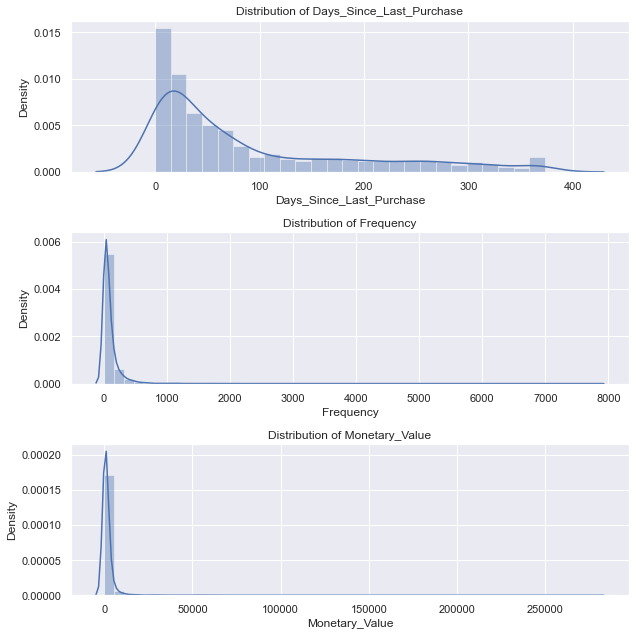

In [439]:
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(segmented_RFM,'Days_Since_Last_Purchase')

plt.subplot(3, 1, 2)
check_skew(segmented_RFM,'Frequency')

plt.subplot(3, 1, 3)
check_skew(segmented_RFM,'Monetary_Value')

plt.tight_layout()
plt.savefig('before_transform.png', format='png', dpi=1000)

##### Data is highly scewed, will perform log-transform and apply standard scaler to normalize data. K-means work better with normalized data.

In [440]:
log_RFM = segmented_RFM[['Days_Since_Last_Purchase', 'Frequency',
       'Monetary_Value']]

Log transform to make data less skewed. Since there are values of 0 (0 days since last purchase, monetary value of 0) I add a small constant since log(0) is undefined and can't be calculated.

Days_Since_Last_Purchase's: Skew: -0.5328030123131506, : SkewtestResult(statistic=-13.530104151364585, pvalue=1.038763674818727e-41)
Frequency's: Skew: -0.02483583032902267, : SkewtestResult(statistic=-0.6706907293691455, pvalue=0.5024175698928065)
Monetary_Value's: Skew: -0.5990076039108273, : SkewtestResult(statistic=-15.00096789635397, pvalue=7.235642790069561e-51)


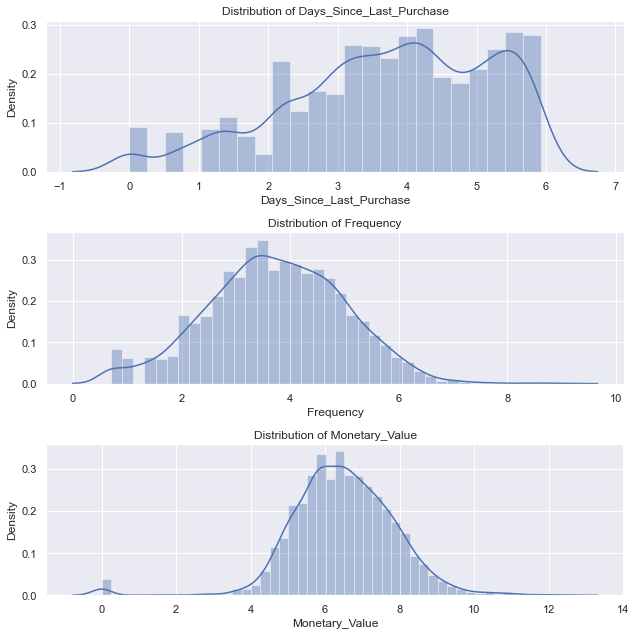

In [441]:
log_RFM = np.log(log_RFM+1)

plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(log_RFM,'Days_Since_Last_Purchase')

plt.subplot(3, 1, 2)
check_skew(log_RFM,'Frequency')

plt.subplot(3, 1, 3)
check_skew(log_RFM,'Monetary_Value')

plt.tight_layout()
plt.savefig('after_transform.png', format='png', dpi=1000)

#### Standard scaler to better fit data 

In [442]:
log_RFM_sd = pd.DataFrame(StandardScaler().fit_transform(log_RFM),columns = ['Days_Since_Last_Purchase', 'Frequency', 'Monetary_Value'])

## Applying the model

### Finding the optimal number of clusters (K)

In [443]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(log_RFM_sd)
    Sum_of_squared_distances.append(km.inertia_)

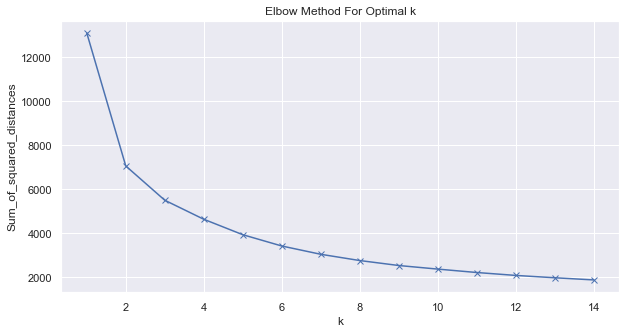

In [444]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

*Elbow point at n_clusters = 2-4, these points show a good trade-off between number of clusters and the SSE, Sum of the Squared Error. A good number of clusters without overfitting the data. Will proceed with 4 it seems like an appropriate amount of clusters based on what we want to do and how many clusters would be appropriate for a bussiness to want to have.*

In [445]:
kmeans = KMeans(
    init="random",
    n_clusters=4,
    n_init=10,
    max_iter=300,
    random_state=42
)

This will perform ten runs of the k-means algorithm on the data with a maximum of 300 iterations per run. Numbers of clusters are set to three.

In [446]:
kmeans.fit(log_RFM_sd)

KMeans(init='random', n_clusters=4, random_state=42)

In [447]:
# The lowest SSE value
kmeans.inertia_

4616.921460747486

In [448]:
# Final locations of the centroid
kmeans.cluster_centers_

array([[ 0.42879105,  0.31996643,  0.28029716],
       [ 0.86090541, -1.03458188, -0.94028963],
       [-1.16028494,  1.24640432,  1.18205929],
       [-0.79840249, -0.23238649, -0.24750648]])

In [449]:
# The number of iterations required to converge
kmeans.n_iter_

15

In [450]:
clusters = kmeans.fit(log_RFM_sd)
predict = clusters.predict(log_RFM_sd)

In [451]:
scatter = go.Scatter3d(x=log_RFM_sd["Days_Since_Last_Purchase"],
                     y=log_RFM_sd["Frequency"],
                     z=log_RFM_sd["Monetary_Value"],
                     mode="markers",
                    opacity=0.9,
                     marker={"color": predict,
                             "size": 2,
                             "line": {"color": predict,
                                      "width":12}});

layout = go.Layout(title="Clusters",
                   scene={"xaxis": {"title": "Days_Since_Last_Purchase"},
                          "yaxis": {"title": "Frequency"},
                          "zaxis": {"title": "Monetary_Value"}});

fig = go.Figure(data=scatter, layout=layout);
plotly.offline.iplot(fig)

We can here see some correlation between the three variables, a customer who buys often and recently often also buy for more, this makes sense. The clusters are not clearly separeted and they are hard to distinguish. This is something to keep in mind in further analysis. 

## Segmentation based on K-Means clustering

Adding the segments to the dataframe, length is the same, rows are specific for the customer

In [452]:
segmented_RFM["KMeanSegment"] = predict

### Recommendations based on segments

In [453]:
segment0 = segmented_RFM[segmented_RFM["KMeanSegment"] == 0]
segment1 = segmented_RFM[segmented_RFM["KMeanSegment"] == 1]
segment2 = segmented_RFM[segmented_RFM["KMeanSegment"] == 2]
segment3 = segmented_RFM[segmented_RFM["KMeanSegment"] == 3]

In [454]:
segment0[['Days_Since_Last_Purchase', 'Frequency',
       'Monetary_Value']].median()

Days_Since_Last_Purchase     72.00
Frequency                    61.00
Monetary_Value              933.94
dtype: float64

In [455]:
segment1[['Days_Since_Last_Purchase', 'Frequency',
       'Monetary_Value']].median()

Days_Since_Last_Purchase    184.00
Frequency                    12.00
Monetary_Value              213.55
dtype: float64

In [456]:
segment2[['Days_Since_Last_Purchase', 'Frequency',
       'Monetary_Value']].median()

Days_Since_Last_Purchase       8.00
Frequency                    189.00
Monetary_Value              3002.24
dtype: float64

In [457]:
segment3[['Days_Since_Last_Purchase', 'Frequency',
       'Monetary_Value']].median()

Days_Since_Last_Purchase     15.000
Frequency                    32.000
Monetary_Value              482.395
dtype: float64

Based on these segments I give the following recommendations: 

##### Segment 0: Lost/Almost Lost Good Customers - Aggresive price incentives, renewals at discount

##### Segment 1: Lost Cheap Customers - Don't bother with them 
    
##### Segment 2: Best Customers - Market them new products, hook them on loyalty programs/keep loyal

##### Segment 3Loyal/Potential Loyal Customers/New Customers - Build relationship, market products based on recent purchases

In [458]:
segmented_RFM.groupby('KMeanSegment').agg({
    'CustomerID': 'count'}).round(1)

,CustomerID
KMeanSegment,
0,1334
1,1311
2,891
3,826
